In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
import vectorbt as vbt
import pandas_ta as ta
import requests
import logging
import sys
import shap
from datasets import load_dataset
from gunsan_strength.core import get_gunsan_strength
from gunsan_strength.plots import plot_gunsan_strength
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from arch import arch_model
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
import os
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from dotenv import load_dotenv
import optuna
from optuna.integration import TFKerasPruningCallback
import warnings
warnings.filterwarnings('ignore')

2025-06-01 16:57:05.261037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748793426.401015  599185 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748793426.794309  599185 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748793428.071720  599185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748793428.071777  599185 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748793428.071781  599185 computation_placer.cc:177] computation placer alr

In [2]:
%pwd

'/home/santoshkumarguntupalli/data_science/Natural_Gas_Price_Forecast/research'

In [3]:
os.chdir('/home/santoshkumarguntupalli/data_science/Natural_Gas_Price_Forecast')
%pwd

'/home/santoshkumarguntupalli/data_science/Natural_Gas_Price_Forecast'

In [4]:
# Configure Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
# Set API key as environment variable
load_dotenv(dotenv_path=".env")
EIA_API_KEY = os.getenv('EIA_API_KEY')

In [6]:
# Function to Download Data with Error Handling
def download_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date, multi_level_index=False)
        data.reset_index(inplace=True)
        return data
    except Exception as e:
        logger.error(f"Failed to download data: {str(e)}")
        sys.exit(1)


In [7]:
# Define Constants
TICKER = 'NG=F'
START_DATE = '2009-01-01'
END_DATE = date.today().strftime("%Y-%m-%d")
TIME_STEP = 60
FORECAST_HORIZON = 30

In [8]:
# Download Data
data = download_data(TICKER, START_DATE, END_DATE)

logger.info(f"Downloaded data from {START_DATE} to {END_DATE}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
INFO:__main__:Downloaded data from 2009-01-01 to 2025-06-01


In [9]:
data

,Date,Close,High,Low,Open,Volume
0,2009-01-02,5.971,6.088,5.503,5.550,41110
1,2009-01-05,6.072,6.142,5.825,5.930,42385
2,2009-01-06,5.983,6.240,5.865,6.083,57506
3,2009-01-07,5.872,6.070,5.784,5.985,48756
4,2009-01-08,5.583,6.004,5.550,5.675,74717
...,...,...,...,...,...,...
4123,2025-05-23,3.334,3.350,3.217,3.283,60597
4124,2025-05-27,3.398,3.445,3.214,3.376,55895
4125,2025-05-28,3.204,3.511,3.152,3.405,204259
4126,2025-05-29,3.522,3.576,3.437,3.535,180662


In [10]:
# Compute GunSan Strength Index
def compute_gunsan_strength(data, signal_window=50):
    try:
        result = get_gunsan_strength(data, signal_window=signal_window)
        return result
    except Exception as e:
        logger.error(f"Failed to compute GunSan Strength: {str(e)}")
        return None
result = compute_gunsan_strength(data)
if result is None:
    sys.exit(1)

In [11]:
# Plot the result
plot_gunsan_strength(result)

In [12]:
result.head()

,Date,Close,Technical_Strength,Technical_Strength_Signal
0,2009-01-02,5.971,NaN,NaN
1,2009-01-05,6.072,NaN,NaN
2,2009-01-06,5.983,NaN,NaN
3,2009-01-07,5.872,NaN,NaN
4,2009-01-08,5.583,NaN,NaN


In [13]:
# Load Utility Gas Heating Degree Days CONUS Data
def load_utility_gas_conus_data():
    dfs = []
    start_date = pd.to_datetime("2010-01-01")
    current_date = pd.to_datetime("today")
    for year in range(start_date.year, current_date.year + 1):
        file_url = f"https://ftp.cpc.ncep.noaa.gov/htdocs/degree_days/weighted/daily_data/{year}/UtilityGas.Heating.txt"
        try:
            response = requests.get(file_url, timeout=10)
            if response.status_code == 200:
                content = response.text
                lines = content.split('\n')
                headers = lines[3].split('|')
                date_headers = [h for h in headers if h.startswith('20')]
                data_lines = lines[4:]
                for line in data_lines:
                    if not line.strip():
                        continue
                    if line.startswith("CONUS|"):
                        parts = line.strip().split('|')
                        hdds = parts[1:]
                        if len(hdds) != len(date_headers):
                            logger.warning(f"Mismatch in date and HDD counts for {year}")
                            continue
                        df = pd.DataFrame({
                            'Date': pd.to_datetime(date_headers, format='%Y%m%d'),
                            'Hdd': list(map(int, hdds)),
                            'year': year
                        })
                        df = df[df['Date'] >= start_date]
                        df.set_index('Date', inplace=True)
                        dfs.append(df)
                        logger.info(f"Loaded CONUS data for {year}")
                        break
        except Exception as e:
            logger.error(f"Failed to load {year}: {str(e)}")
    if dfs:
        return pd.concat(dfs)
    else:
        return None


In [14]:
hdd_df = load_utility_gas_conus_data()
if hdd_df is not None:
    logger.info("Filtered CONUS HDD data loaded successfully!")
else:
    logger.error("No CONUS data was loaded.")
    sys.exit(1)

INFO:__main__:Loaded CONUS data for 2010
INFO:__main__:Loaded CONUS data for 2011
INFO:__main__:Loaded CONUS data for 2012
INFO:__main__:Loaded CONUS data for 2013
INFO:__main__:Loaded CONUS data for 2014
INFO:__main__:Loaded CONUS data for 2015
INFO:__main__:Loaded CONUS data for 2016
INFO:__main__:Loaded CONUS data for 2017
INFO:__main__:Loaded CONUS data for 2018
INFO:__main__:Loaded CONUS data for 2019
INFO:__main__:Loaded CONUS data for 2020
INFO:__main__:Loaded CONUS data for 2021
INFO:__main__:Loaded CONUS data for 2022
INFO:__main__:Loaded CONUS data for 2023
INFO:__main__:Loaded CONUS data for 2024
INFO:__main__:Loaded CONUS data for 2025
INFO:__main__:Filtered CONUS HDD data loaded successfully!


In [15]:
# Fetch Inventory Data
def fetch_inventory_bcf_eia(start_dt='2010-01-01', end_dt=None, api_key=None):
    if end_dt is None:
        end_dt = date.today().strftime("%Y-%m-%d")
    if api_key is None:
        logger.error("Please provide your EIA API key.")
        sys.exit(1)
    url = (
        "https://api.eia.gov/v2/natural-gas/stor/wkly/data/"
        f"?api_key={api_key}"
        "&frequency=weekly"
        "&data[0]=value"
        "&facets[series][]=NW2_EPG0_SWO_R48_BCF"
        f"&start={start_dt}"
        f"&end={end_dt}"
        "&sort[0][column]=period"
        "&sort[0][direction]=asc"
        "&offset=0"
        "&length=5000"
    )
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data_json = response.json()
        if 'response' in data_json and 'data' in data_json['response']:
            records = data_json['response']['data']
            df_storage = pd.DataFrame(records)
            df_storage['Date'] = pd.to_datetime(df_storage['period'])
            df_storage = df_storage.rename(columns={'value': 'Inventory_Bcf'})
            df_storage['Inventory_Bcf'] = df_storage['Inventory_Bcf'].astype(int)
            df_storage = df_storage[['Date', 'Inventory_Bcf']].sort_values('Date')
            df_storage = df_storage.set_index('Date').resample('D').ffill()
            return df_storage
        else:
            logger.error("API Error:", data_json.get('error', 'Unknown issue'))
            return None
    except Exception as e:
        logger.error(f"Failed to fetch inventory data: {str(e)}")
        return None

In [16]:
df_inventory = fetch_inventory_bcf_eia(api_key=EIA_API_KEY, end_dt=END_DATE)
if df_inventory is not None:
    logger.info("Inventory data loaded successfully!")
else:
    logger.error("Failed to load inventory data.")
    sys.exit(1)

INFO:__main__:Inventory data loaded successfully!


In [17]:
result

,Date,Close,Technical_Strength,Technical_Strength_Signal
0,2009-01-02,5.971,NaN,NaN
1,2009-01-05,6.072,NaN,NaN
2,2009-01-06,5.983,NaN,NaN
3,2009-01-07,5.872,NaN,NaN
4,2009-01-08,5.583,NaN,NaN
...,...,...,...,...
4123,2025-05-23,3.334,0.087317,0.089817
4124,2025-05-27,3.398,0.109431,0.083310
4125,2025-05-28,3.204,0.011015,0.076231
4126,2025-05-29,3.522,-0.012027,0.068041


In [18]:
result["Return"]=result['Close'].pct_change()
result['Hist_Vol'] = result['Return'].rolling(window=252).std() * np.sqrt(252)
result["Volume"]=data["Volume"]

In [19]:
# Merge and Prepare Data
result = pd.merge(result, hdd_df["Hdd"], on='Date', how='left')
result = pd.merge(result, df_inventory, on='Date', how='left')
result = result[result['Date']>= '2010-01-01']

In [20]:
print(result.isnull().sum())

Date                         0
Close                        0
Technical_Strength           0
Technical_Strength_Signal    0
Return                       0
Hist_Vol                     0
Volume                       0
Hdd                          0
Inventory_Bcf                4
dtype: int64


In [21]:
# Handle Missing Values
result['Inventory_Bcf'] = result['Inventory_Bcf'].interpolate(method='linear', limit_direction='both')
result['Hdd'] = result['Hdd'].interpolate(method='linear', limit_direction='both')

In [22]:
result.head()

,Date,Close,Technical_Strength,Technical_Strength_Signal,Return,Hist_Vol,Volume,Hdd,Inventory_Bcf
252,2010-01-04,5.884,0.520376,0.276366,0.055994,0.780515,78858,39.0,3117.0
253,2010-01-05,5.637,0.425686,0.278883,-0.041978,0.781538,99492,38.0,3117.0
254,2010-01-06,6.009,0.610025,0.289526,0.065993,0.784088,140611,36.0,3117.0
255,2010-01-07,5.806,0.618388,0.301580,-0.033783,0.784620,135113,36.0,3117.0
256,2010-01-08,5.749,0.504525,0.311377,-0.009817,0.783070,101153,39.0,2850.0


In [23]:
# Feature Engineering
def add_features(df):
    df['Inventory_Bcf_lag3'] = df['Inventory_Bcf'].shift(3)
    df['Hdd_ma30'] = df['Hdd'].rolling(window=30).mean()
    df['Inventory_ma30'] = df['Inventory_Bcf'].rolling(window=30).mean()
    df['Hdd_cumsum'] = df['Hdd'].cumsum()
    df['Inventory_cumsum'] = df['Inventory_Bcf'].cumsum()
    df['Volume_ma30'] = df['Volume'].rolling(window=30).mean()
    df['Volume_cumsum'] = df['Volume'].cumsum()
    return df

In [24]:
result = add_features(result)
result = result.dropna()

In [25]:
result.isnull().sum()

Date                         0
Close                        0
Technical_Strength           0
Technical_Strength_Signal    0
Return                       0
Hist_Vol                     0
Volume                       0
Hdd                          0
Inventory_Bcf                0
Inventory_Bcf_lag3           0
Hdd_ma30                     0
Inventory_ma30               0
Hdd_cumsum                   0
Inventory_cumsum             0
Volume_ma30                  0
Volume_cumsum                0
dtype: int64

In [26]:
import plotly.graph_objects as go

fig = go.Figure()

# Inventory_Bcf (left axis)
fig.add_trace(go.Scatter(
    x=result.index,
    y=result['Inventory_ma30'],
    name='Inventory_Bcf',
    yaxis='y',
    line=dict(color='#1ABC9C')
))

# HDD (right axis)
fig.add_trace(go.Scatter(
    x=result.index,
    y=result['Hdd_ma30'],
    name='HDD',
    yaxis='y2',
    line=dict(color='#F39C12')
))

# Close Price (far-right axis)
fig.add_trace(go.Scatter(
    x=result.index,
    y=result['Close'],
    name='Close Price',
    yaxis='y3',
    line=dict(color='#3498DB')
))

# 🔧 Layout with 3 y-axes
fig.update_layout(
    title='Inventory, HDD, and Natural Gas Price (Multi-Axis)',
    xaxis=dict(
        domain=[0.1, 0.85]
    ),
    yaxis=dict(  # y (left)
        title='Inventory_Bcf',
        titlefont=dict(color='#1ABC9C'),
        tickfont=dict(color='#1ABC9C'),
        anchor='x',
        side='left',
        position=0.0
    ),
    yaxis2=dict(  # y2 (right)
        title='HDD',
        titlefont=dict(color='#F39C12'),
        tickfont=dict(color='#F39C12'),
        anchor='x',
        overlaying='y',
        side='right',
        position=0.85
    ),
    yaxis3=dict(  # y3 (far-right)
        title='Close Price',
        titlefont=dict(color='#3498DB'),
        tickfont=dict(color='#3498DB'),
        anchor='free',
        overlaying='y',
        side='right',
        position=1.0
    ),
    legend=dict(x=0.5, y=1.15, orientation='h'),
    margin=dict(l=60, r=80, t=80, b=40),
    width=1100,
    height=500
)

fig.show()


In [27]:
# Define float32/float64 types
feature_dtypes = {
    'Close': 'float32',
    'Technical_Strength': 'float32',
    'Technical_Strength_Signal': 'float32',
    'Hist_Vol': 'float32',
    'Inventory_Bcf': 'float32',
    'Inventory_Bcf_lag3': 'float32',
    'Hdd_ma30': 'float32',
    'Inventory_ma30': 'float32',
    'Hdd_cumsum': 'float32',
    'Inventory_cumsum': 'float64',  
    'Volume_ma30': 'float32',
    'Volume_cumsum': 'float64'      
}


In [28]:
df_lstm_final = pd.read_csv("research/processed_data.csv")

In [29]:
# Split Data
def split_data(data, test_size=0.25, random_state=42):
    try:
        df_train, df_test = train_test_split(data, test_size=test_size, shuffle=False, random_state=random_state)

        return df_train, df_test
    except Exception as e:
        logger.error(f"Failed to split data: {str(e)}")
        return None
    
df_model = df_lstm_final.drop(columns=['Date', 'Return', 'Volume', 'Hdd'])
df_model = df_model.round(2).astype(feature_dtypes)

df_train, df_test = split_data(df_model)
if df_train is None:
    sys.exit(1)

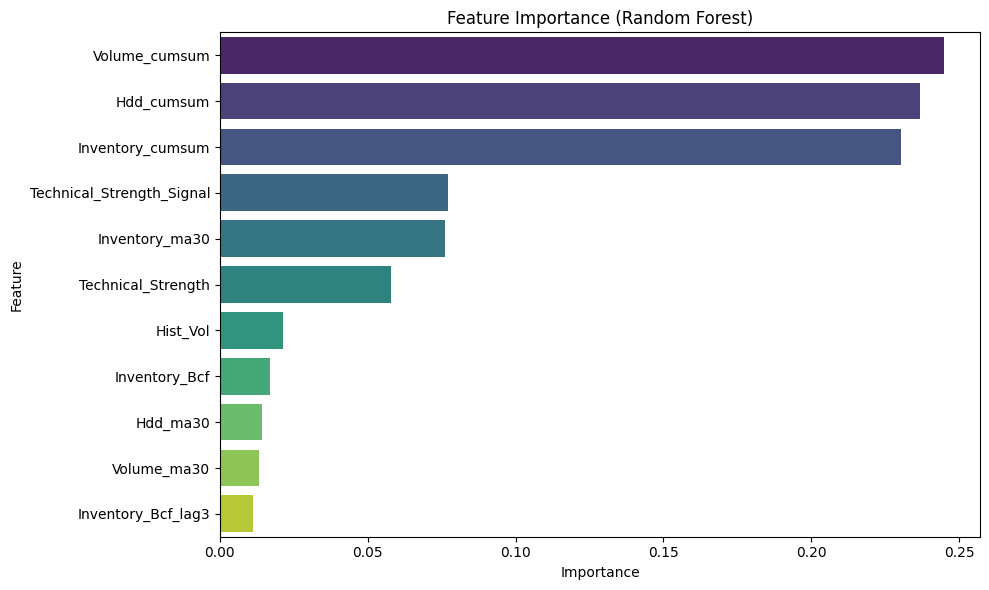

In [30]:
importances_model = RandomForestRegressor(n_estimators=100, random_state=42)
importances_model.fit(df_train.drop(columns=['Close']), df_train['Close'])

# Get feature importances
importances = importances_model.feature_importances_
feature_names = df_train.drop(columns=['Close']).columns

# Create a nice plot
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

In [31]:
importance_df

,Feature,Importance
10,Volume_cumsum,0.244803
7,Hdd_cumsum,0.236891
8,Inventory_cumsum,0.230322
1,Technical_Strength_Signal,0.076997
6,Inventory_ma30,0.076186
0,Technical_Strength,0.057756
3,Hist_Vol,0.021343
2,Inventory_Bcf,0.016812
5,Hdd_ma30,0.014240
9,Volume_ma30,0.013316


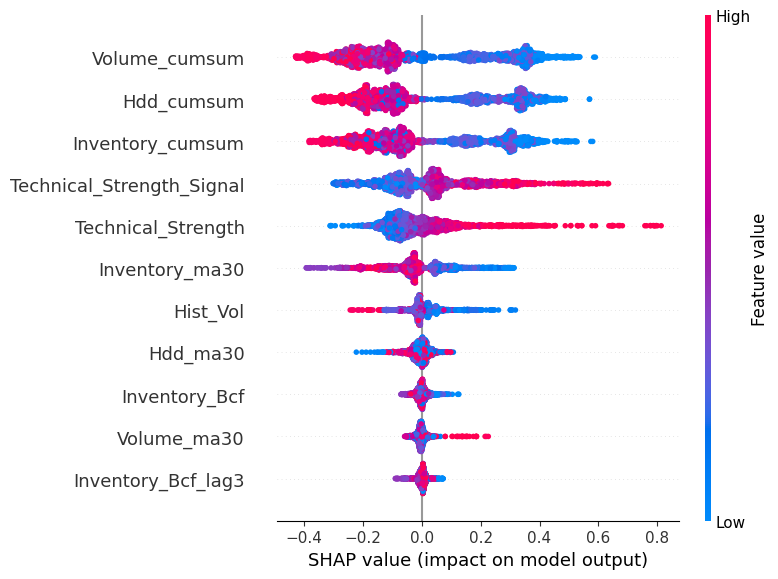

In [32]:
explainer = shap.Explainer(importances_model)
shap_values = explainer(df_train.drop(columns=['Close']))

shap.summary_plot(shap_values, df_train.drop(columns=['Close']))

In [33]:
correlations = result.corr()
correlations['Close'].sort_values(ascending=False)


Close                        1.000000
Technical_Strength_Signal    0.664058
Technical_Strength           0.556420
Hist_Vol                     0.340027
Return                       0.055703
Hdd                         -0.013655
Hdd_ma30                    -0.047420
Volume_cumsum               -0.061819
Date                        -0.072872
Inventory_cumsum            -0.073513
Hdd_cumsum                  -0.077132
Inventory_Bcf               -0.132135
Inventory_Bcf_lag3          -0.134986
Inventory_ma30              -0.157132
Volume                      -0.164157
Volume_ma30                 -0.340640
Name: Close, dtype: float64

<Axes: >

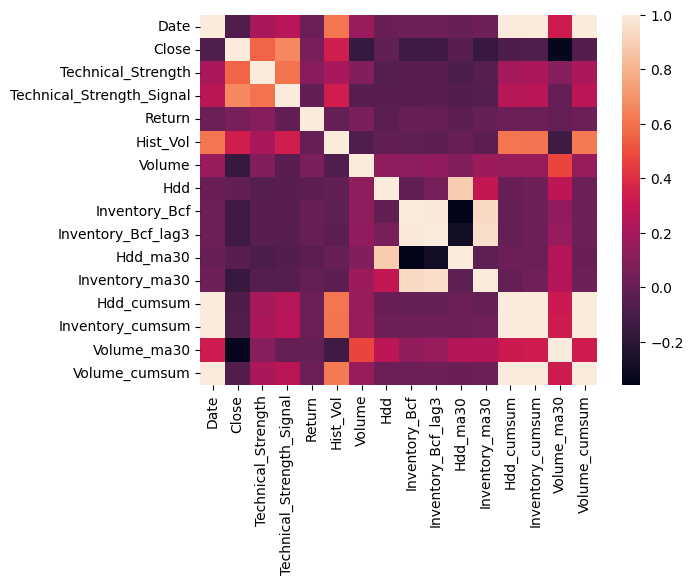

In [34]:
sns.heatmap(correlations)

In [35]:
# Scale feature Data
def scale_feature_data(train_data, test_data):
    try:
        feature_scaler = StandardScaler()
        scaled_train = feature_scaler.fit_transform(train_data)
        scaled_test = feature_scaler.transform(test_data)
        return scaled_train, scaled_test, feature_scaler
    except Exception as e:
        logger.error(f"Failed to scale data: {str(e)}")
        return None
    
scaled_train, scaled_test, feature_scaler = scale_feature_data(df_train, df_test)
if scaled_train is None:
    sys.exit(1)

In [36]:
# Scale Target
def scale_target_vector(train_data, test_data):
    try:
        close_scaler = StandardScaler()
        scaled_train = close_scaler.fit_transform(train_data)
        scaled_test = close_scaler.transform(test_data)
        return scaled_train, scaled_test, close_scaler
    except Exception as e:
        logger.error(f"Failed to scale data: {str(e)}")
        return None
    
scaled_target_train, scaled_target_test, close_scaler = scale_target_vector(df_train[['Close']], df_test[['Close']])
if scaled_target_train is None:
    sys.exit(1)


In [37]:
result.columns

Index(['Date', 'Close', 'Technical_Strength', 'Technical_Strength_Signal',
       'Return', 'Hist_Vol', 'Volume', 'Hdd', 'Inventory_Bcf',
       'Inventory_Bcf_lag3', 'Hdd_ma30', 'Inventory_ma30', 'Hdd_cumsum',
       'Inventory_cumsum', 'Volume_ma30', 'Volume_cumsum'],
      dtype='object')

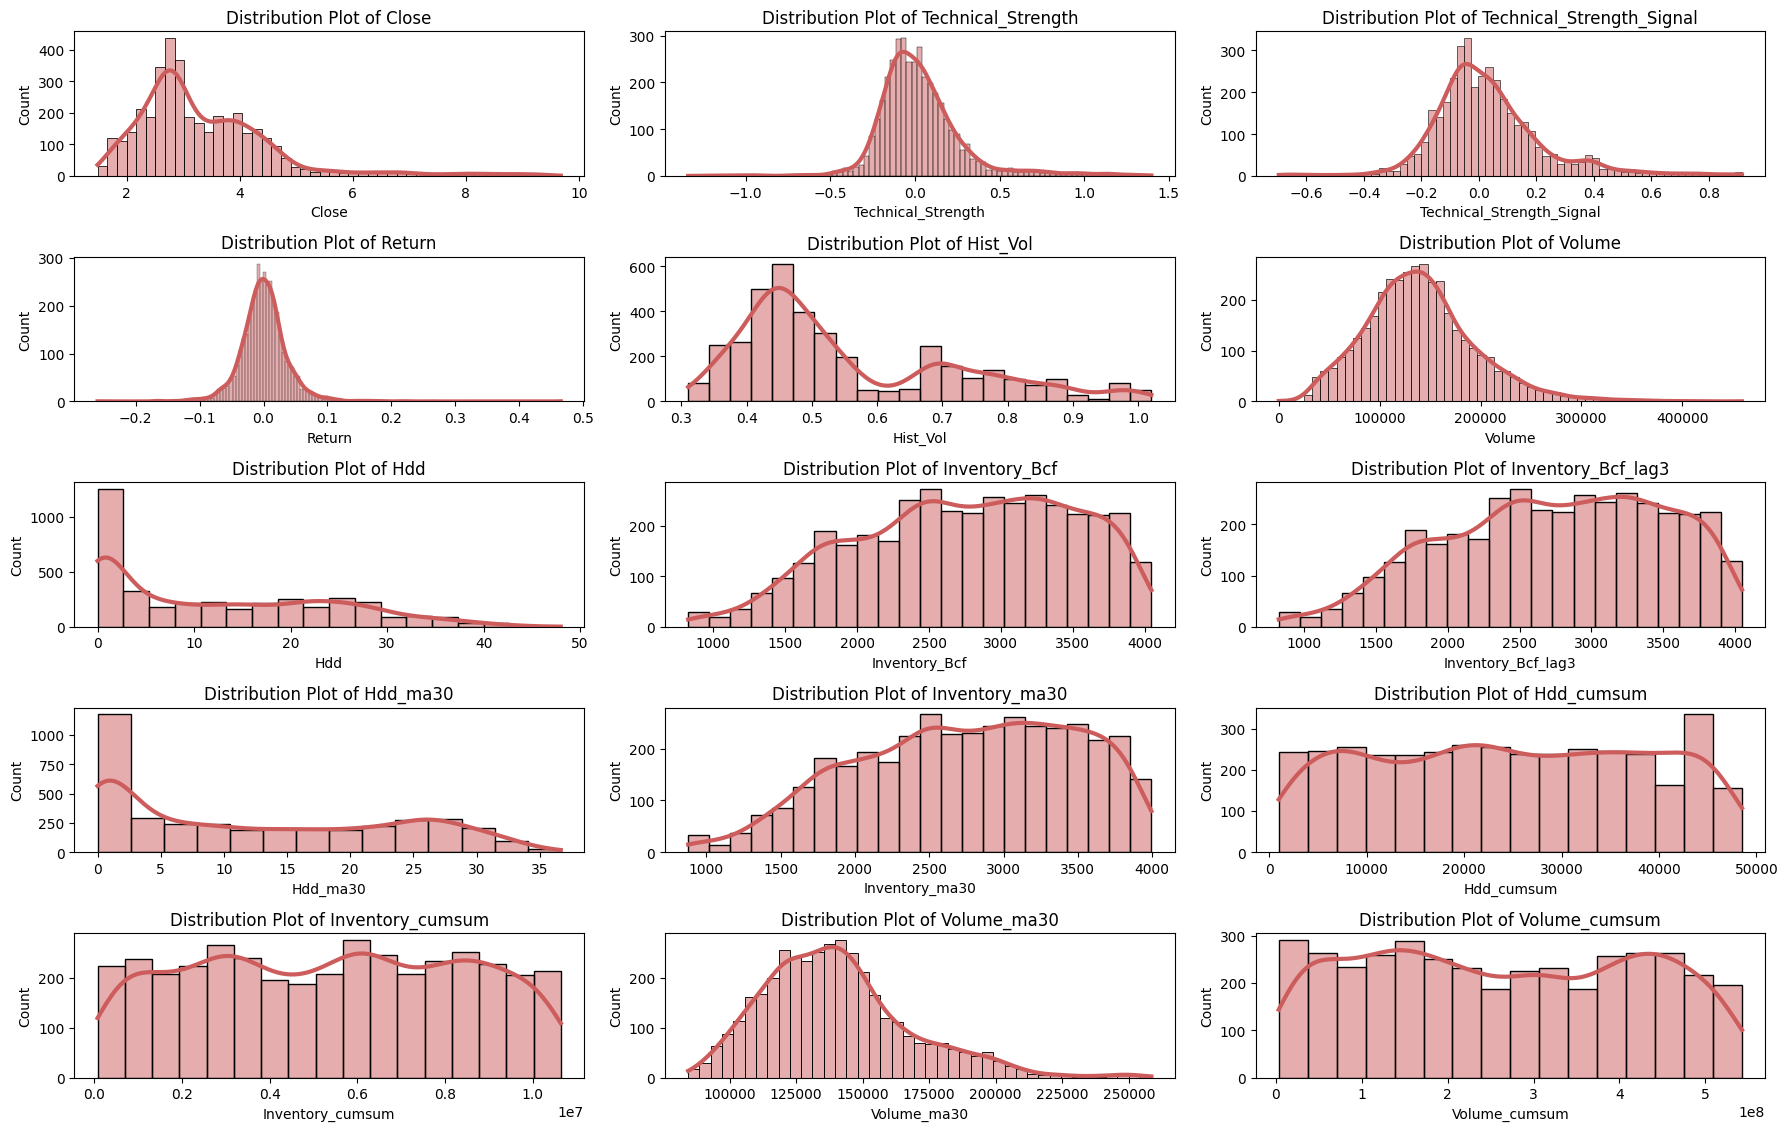

In [38]:
columns_to_plot = [col for col in result.columns if col != 'Date']
plt.figure(figsize=(18,20))
for i,col in enumerate(columns_to_plot,1):
    plt.subplot(9,3,i)
    sns.histplot(result[col],kde=True, color="indianred",line_kws={"linewidth": 3})
    plt.title(f"Distribution Plot of {col}")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


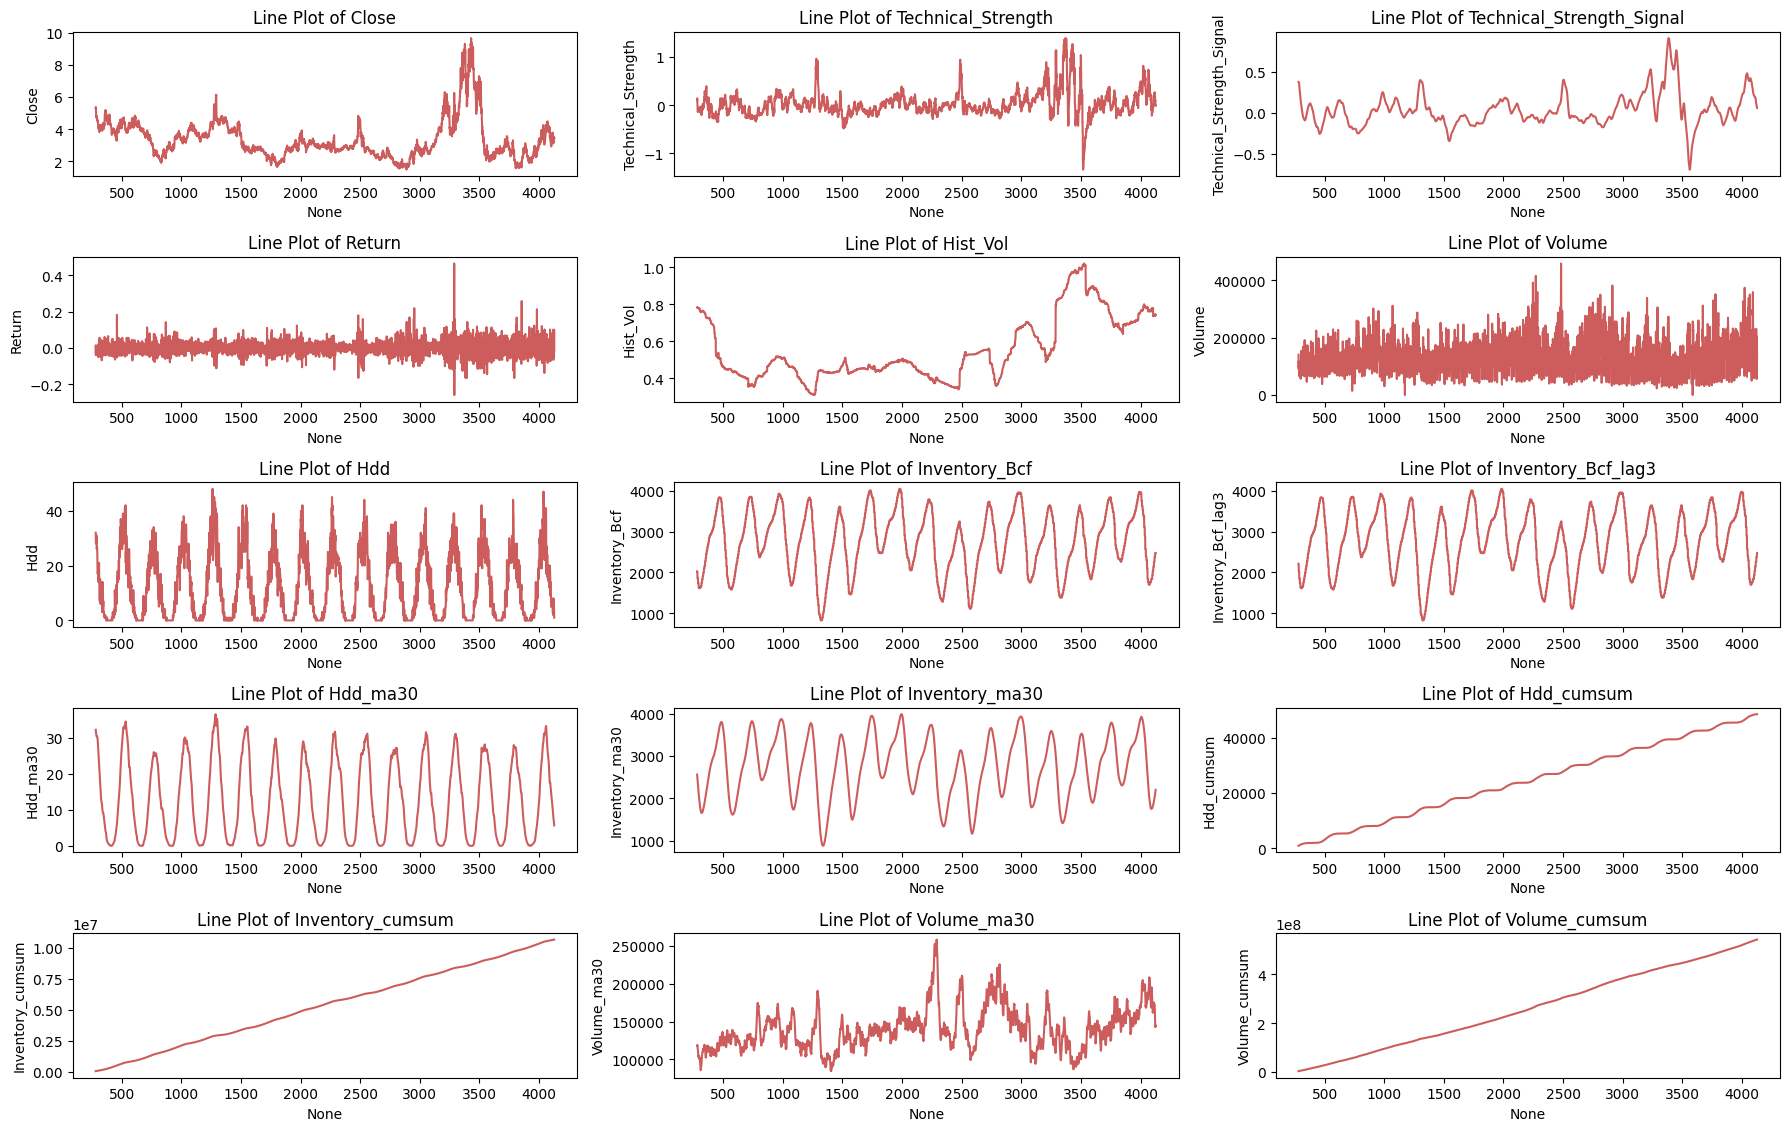

In [39]:
columns_to_plot = [col for col in result.columns if col != 'Date']
plt.figure(figsize=(18,20))
for i,col in enumerate(columns_to_plot,1):
    plt.subplot(9,3,i)
    sns.lineplot(x=result.index, y=result[col], color="indianred")
    plt.title(f"Line Plot of {col}")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [40]:
scaled_train

array([[ 2.65351358,  0.65934991,  2.91203465, ..., -1.72918761,
        -0.74948537, -1.62983035],
       [ 2.75230084,  0.83249533,  2.91203465, ..., -1.72833875,
        -0.73483969, -1.62905108],
       [ 2.48063589,  0.37077421,  2.91203465, ..., -1.72750883,
        -0.71224861, -1.62803829],
       ...,
       [ 1.08526446,  1.64050727,  1.69877237, ...,  1.71501968,
        -0.9118808 ,  1.79349558],
       [ 1.10996127,  1.58279219,  1.7746013 , ...,  1.71621206,
        -0.9033879 ,  1.79450761],
       [ 0.92473517,  1.35193159,  1.7746013 , ...,  1.71740558,
        -0.88937202,  1.79589064]])

In [41]:
# Sequence generation
def create_sequences(data, target, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])
        y.append(target[i])
    return np.array(X), np.array(y)

TIME_STEP = 60
X_train_seq, y_train_seq = create_sequences(scaled_train, scaled_target_train, TIME_STEP)
X_test_seq, y_test_seq = create_sequences(scaled_test, scaled_target_test, TIME_STEP)


In [ ]:
# Define LSTM Model for Optuna
def objective(trial):
    # Hyperparameters
    layers = trial.suggest_int('layers', 1, 3)
    units = trial.suggest_categorical('units', [32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Build model
    model = Sequential()
    for i in range(layers):
        return_seq = i < layers - 1
        if i == 0:
            model.add(LSTM(units, return_sequences=return_seq, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
        else:
            model.add(LSTM(units, return_sequences=return_seq))
        model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')

    # Train
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=100,
        batch_size=batch_size,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            TFKerasPruningCallback(trial, "val_loss")
        ],
        verbose=0
    )

    # Return final validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

In [ ]:
# Run Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60)

# Best Trial Info
print(f"Best Trial:\n  Value: {study.best_trial.value}\n  Params: {study.best_trial.params}")

[I 2025-06-01 17:03:50,982] A new study created in memory with name: no-name-cfac0df4-8d4d-49d0-8475-ccd9d25394ed
2025-06-01 17:03:51.226152: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
[I 2025-06-01 17:15:53,431] Trial 0 finished with value: 2.231377124786377 and parameters: {'layers': 3, 'units': 128, 'dropout': 0.2861027955771372, 'learning_rate': 0.00894951161023097, 'batch_size': 64}. Best is trial 0 with value: 2.231377124786377.
[I 2025-06-01 17:23:50,966] Trial 1 finished with value: 1.4002673625946045 and parameters: {'layers': 2, 'units': 128, 'dropout': 0.23530811732698972, 'learning_rate': 0.000799531267224008, 'batch_size': 128}. Best is trial 1 with value: 1.4002673625946045.
[I 2025-06-01 17:27:40,822] Trial 2 finished with value: 2.3020553588867188 and parameters: {'layers': 1, 'units': 64, 'dropout': 0.30203505482686144, 'learning_rate': 0.0002548988841465381,

Best Trial:
  Value: 0.6157642006874084
  Params: {'layers': 1, 'units': 128, 'dropout': 0.474381420780048, 'learning_rate': 0.005563285496088541, 'batch_size': 32}


In [ ]:
best_params = study.best_trial.params

final_model = Sequential()
for i in range(best_params['layers']):
    return_seq = i < best_params['layers'] - 1
    if i == 0:
        final_model.add(LSTM(best_params['units'], return_sequences=return_seq, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    else:
        final_model.add(LSTM(best_params['units'], return_sequences=return_seq))
    final_model.add(Dropout(best_params['dropout']))
final_model.add(Dense(1))
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                    loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-6)

In [71]:
final_model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_46                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [72]:
best_params

{'layers': 1,
 'units': 128,
 'dropout': 0.474381420780048,
 'learning_rate': 0.005563285496088541,
 'batch_size': 32}

In [73]:
# Train
history = final_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=300,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - loss: 0.2448 - val_loss: 2.0446 - learning_rate: 0.0056
Epoch 2/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 0.0505 - val_loss: 1.8342 - learning_rate: 0.0056
Epoch 3/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - loss: 0.0505 - val_loss: 1.5389 - learning_rate: 0.0056
Epoch 4/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - loss: 0.0331 - val_loss: 0.9908 - learning_rate: 0.0056
Epoch 5/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - loss: 0.0389 - val_loss: 1.1709 - learning_rate: 0.0056
Epoch 6/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - loss: 0.0389 - val_loss: 1.3319 - learning_rate: 0.0056
Epoch 7/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - loss: 0.0328 - val_loss: 1.1433 - learning_rate: 0.0056
Epoch 8/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - loss: 0.0339 - val_loss: 1.1147 - learning_rate: 0.0056
Epoch 9/300
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - loss: 0.0303 - val_loss: 0.8090 - learning_rate:

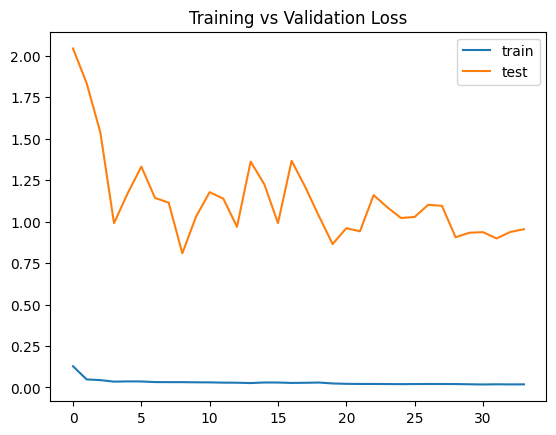

In [74]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [75]:
# Predict & Inverse transform
y_pred = final_model.predict(X_test_seq)
predicted_close = close_scaler.inverse_transform(y_pred)
actual_close = close_scaler.inverse_transform(y_test_seq)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


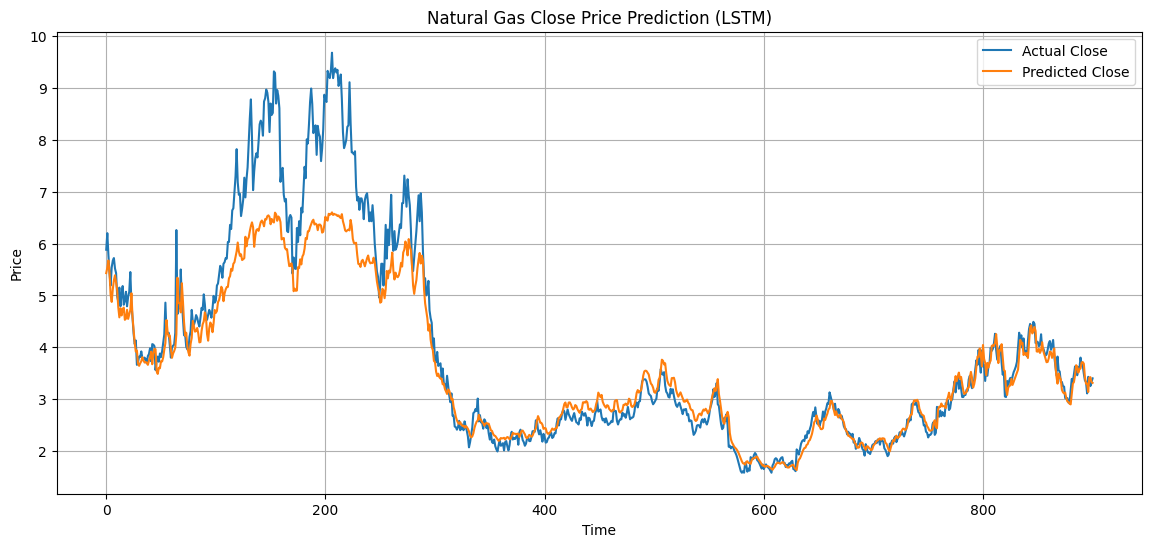

In [76]:
# Plot Actual vs Predicted
plt.figure(figsize=(14,6))
plt.plot(actual_close, label='Actual Close')
plt.plot(predicted_close, label='Predicted Close')
plt.title('Natural Gas Close Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
# Evaluation
rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.7284
MAE: 0.4125


In [78]:
# Future period 30 day volume simulation using Facebook Prophet
volume_df = data[['Date', 'Volume']].rename(columns={'Date': 'ds', 'Volume': 'y'})

model_vol = Prophet(
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_range=0.95,
    changepoint_prior_scale=0.2  # Increased flexibility
)
# Add custom seasonalities
model_vol.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_vol.fit(volume_df)

future_vol = model_vol.make_future_dataframe(periods=30)
forecast_vol = model_vol.predict(future_vol)

future_volume = forecast_vol['yhat'].iloc[-30:].values



DEBUG:cmdstanpy:input tempfile: /tmp/tmpcm9adr5z/s2szlbn5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcm9adr5z/twp3b8oi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71788', 'data', 'file=/tmp/tmpcm9adr5z/s2szlbn5.json', 'init=/tmp/tmpcm9adr5z/twp3b8oi.json', 'output', 'file=/tmp/tmpcm9adr5z/prophet_model3qsnw85r/prophet_model-20250601195051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [79]:
result=result.reset_index()

In [80]:
# Future period 30 day technical strength simulation using Facebook Prophet
ts_df = result[['Date', 'Technical_Strength']].dropna().rename(columns={'Date': 'ds', 'Technical_Strength': 'y'})

model_ts = Prophet()
model_ts.fit(ts_df)

future_ts = model_ts.make_future_dataframe(periods=30)
forecast_ts = model_ts.predict(future_ts)

future_strength = forecast_ts['yhat'].iloc[-30:].values


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcm9adr5z/erap8jva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcm9adr5z/evc3k41t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92187', 'data', 'file=/tmp/tmpcm9adr5z/erap8jva.json', 'init=/tmp/tmpcm9adr5z/evc3k41t.json', 'output', 'file=/tmp/tmpcm9adr5z/prophet_model_iiwbbbu/prophet_model-20250601195100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [81]:
# Future period 30 day heating degree days using Facebook Prophet
hdd_df = result[['Date', 'Hdd']].dropna().rename(columns={'Date': 'ds', 'Hdd': 'y'})

model_hdd = Prophet(
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_range=0.95,
    changepoint_prior_scale=0.2  # Increased flexibility
)
# Add custom seasonalities
model_hdd.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_hdd.fit(hdd_df)

future_hdd = model_hdd.make_future_dataframe(periods=30)
forecast_hdd = model_hdd.predict(future_hdd)

future_hdd = forecast_hdd['yhat'].iloc[-30:].values


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcm9adr5z/ovvxsqp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcm9adr5z/rufvk9h1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28504', 'data', 'file=/tmp/tmpcm9adr5z/ovvxsqp3.json', 'init=/tmp/tmpcm9adr5z/rufvk9h1.json', 'output', 'file=/tmp/tmpcm9adr5z/prophet_modelrxffohhl/prophet_model-20250601195102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [82]:
# Future period 30 day heating degree days using Facebook Prophet
bcf_df = result[['Date', 'Inventory_Bcf']].dropna().rename(columns={'Date': 'ds', 'Inventory_Bcf': 'y'})

model_bcf = Prophet(
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_range=0.95,
    changepoint_prior_scale=0.2  # Increased flexibility
)
# Add custom seasonalities
model_bcf.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_bcf.fit(bcf_df)

future_bcf = model_bcf.make_future_dataframe(periods=30)
forecast_bcf = model_bcf.predict(future_bcf)

future_bcf = forecast_bcf['yhat'].iloc[-30:].values


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcm9adr5z/aupmkgr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcm9adr5z/cobw11hq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/santoshkumarguntupalli/miniconda3/envs/myenv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4813', 'data', 'file=/tmp/tmpcm9adr5z/aupmkgr6.json', 'init=/tmp/tmpcm9adr5z/cobw11hq.json', 'output', 'file=/tmp/tmpcm9adr5z/prophet_model1bhi4bfe/prophet_model-20250601195109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [83]:


# Take only returns with no NaN
returns = result['Return'].dropna() * 100  # percentage scale

# How many days to forecast ahead (adjustable)
forecast_horizon = 30

# Initialize list for rolling predictions
rolling_predictions = []

# Rolling forecast (similar to your reference)
for i in range(forecast_horizon):
    train_data = returns[:-(forecast_horizon - i)]
    
    garch_model = arch_model(train_data, dist="ged", vol='GARCH', p=1, q=1)
    model_fit = garch_model.fit(disp='off')
    
    # Forecast 1-day ahead volatility (variance), take sqrt and scale back
    forecast = model_fit.forecast(horizon=1, reindex=False)
    next_vol = np.sqrt(forecast.variance.values[-1][0])*np.sqrt(252)
    rolling_predictions.append(next_vol/100)

# Convert to pandas Series
last_date = result['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

future_volatility_series = pd.Series(rolling_predictions, index=future_dates, name='Predicted_Hist_Vol')


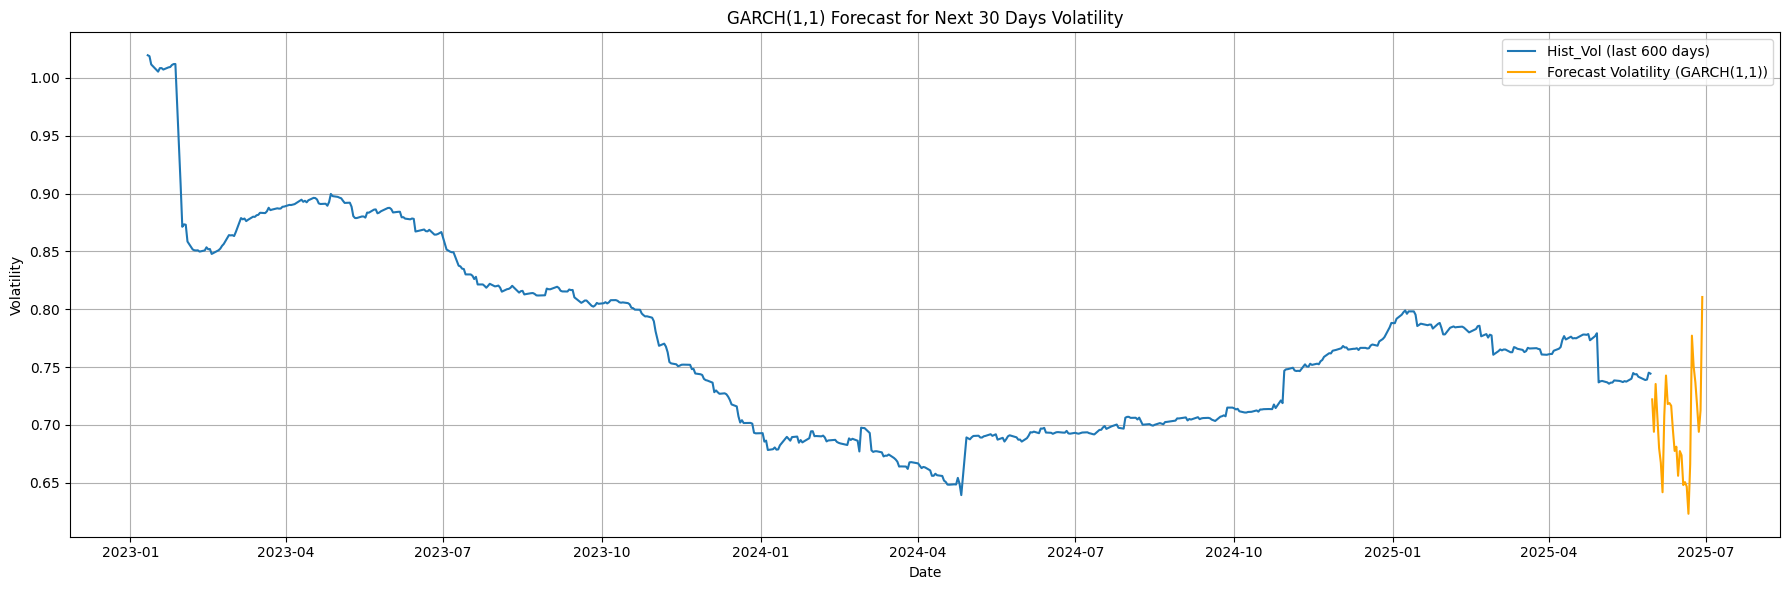

In [84]:
# Plot
plt.figure(figsize=(18,6))
plt.plot(result['Date'].iloc[-600:], result['Hist_Vol'].iloc[-600:], label='Hist_Vol (last 600 days)')
plt.plot(future_volatility_series, label='Forecast Volatility (GARCH(1,1))', linestyle='-', color='orange')
plt.title("GARCH(1,1) Forecast for Next 30 Days Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [85]:
# Combine last known 60 rows with future simulated features
last_known = df_model.iloc[-60:].copy()


In [86]:
# Future Gunsan Strength Signal
ts_full_for_signal = pd.concat([
    result['Technical_Strength'].iloc[-252:],  # Last known
    pd.Series(future_strength, index=future_dates)  # Simulated
])
future_signal = ts_full_for_signal.rolling(252).mean().loc[future_dates]

# Future Inventory Feature Engineering
inv_bcf_for_signal = pd.concat([
    result['Inventory_Bcf'].iloc[-40:],  # Last known
    pd.Series(future_bcf, index=future_dates)  # Simulated
])
last_inventory_cumsum = df_model['Inventory_cumsum'].iloc[-1]
future_inventory_lag3 = inv_bcf_for_signal.shift(3).loc[future_dates]
future_inventory_cumsum = inv_bcf_for_signal.cumsum().loc[future_dates]+last_inventory_cumsum
future_inventory_ma30 = inv_bcf_for_signal.rolling(window=30).mean().loc[future_dates]

# Future HDD Feature Engineering
hdd_for_signal = pd.concat([
    result['Hdd'].iloc[-40:],  # Last known
    pd.Series(future_hdd, index=future_dates)  # Simulated
])
last_hdd_cumsum = df_model['Hdd_cumsum'].iloc[-1]
future_hdd_cumsum = hdd_for_signal.cumsum().loc[future_dates]+last_hdd_cumsum
future_hdd_ma30 = hdd_for_signal.rolling(window=30).mean().loc[future_dates]

# Future Volume Feature Engineering
volume_for_signal = pd.concat([
    result['Volume'].iloc[-40:],  # Last known
    pd.Series(future_volume, index=future_dates)  # Simulated
])
last_volume_cumsum = df_model['Volume_cumsum'].iloc[-1]
future_volume_cumsum = volume_for_signal.cumsum().loc[future_dates]+last_volume_cumsum
future_volume_ma30 = volume_for_signal.rolling(window=30).mean().loc[future_dates]





In [87]:
# Add the simulated values to form a future frame
future_data = pd.DataFrame({
    'Close': 0,  # dummy
    'Technical_Strength': future_strength,
    'Technical_Strength_Signal': future_signal,
    'Hist_Vol': future_volatility_series,
    'Inventory_Bcf': future_bcf,
    'Inventory_Bcf_lag3': future_inventory_lag3,
    'Hdd_ma30': future_hdd_ma30,
    'Inventory_ma30': future_inventory_ma30,
    'Hdd_cumsum': future_hdd_cumsum,
    'Inventory_cumsum': future_inventory_cumsum,
    'Volume_ma30': future_volume_ma30,
    'Volume_cumsum': future_volume_cumsum
}, index=future_dates)

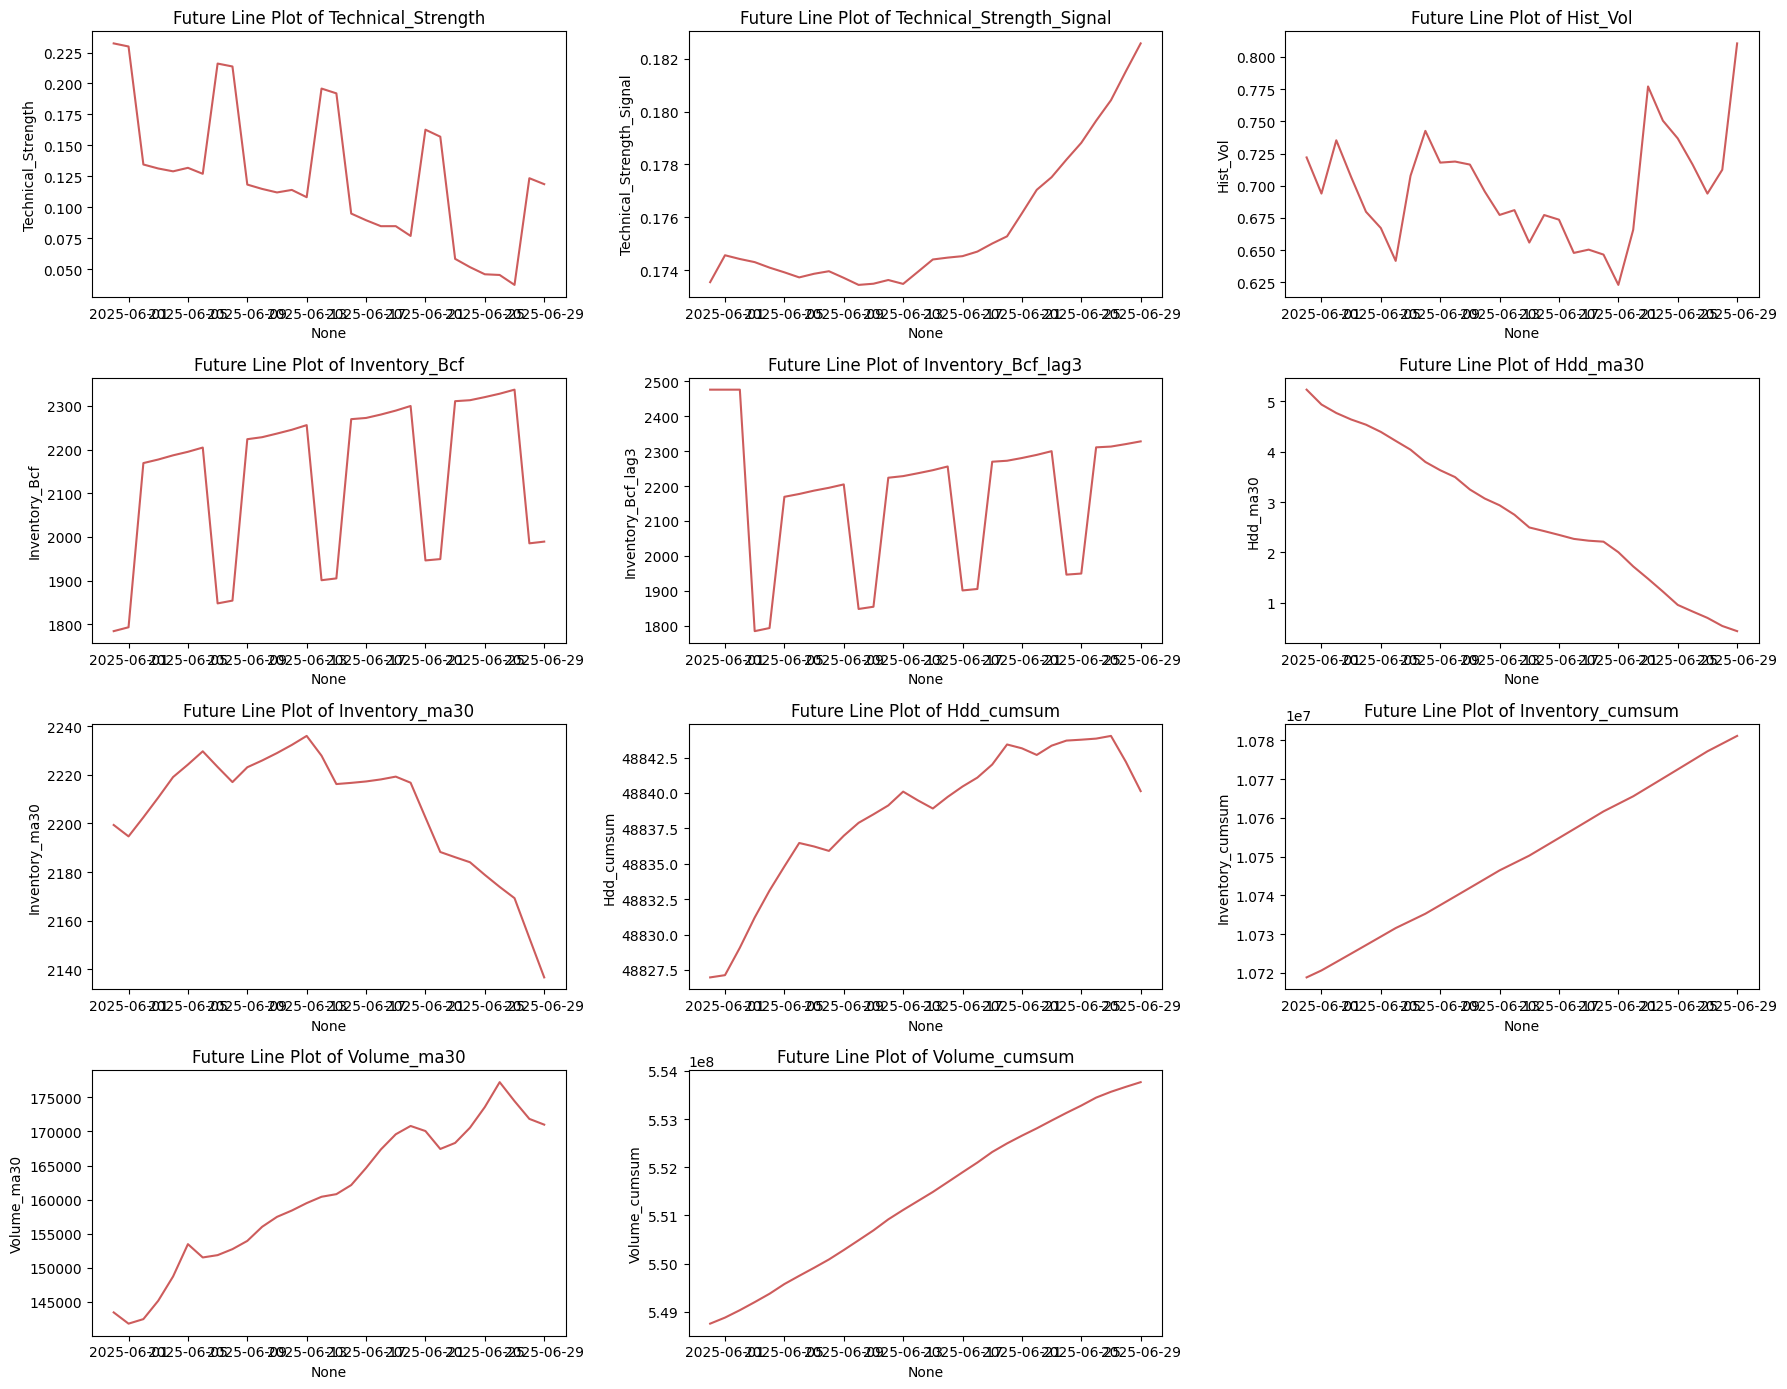

In [88]:
columns_to_plot = [col for col in future_data.columns if col != 'Close']
plt.figure(figsize=(18, 14))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(4, 3, i)
    sns.lineplot(x=future_data.index, y=future_data[col], color="indianred")
    plt.title(f"Future Line Plot of {col}")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [89]:
# Reorder columns to match training set
future_data = future_data[df_model.columns]
future_data = future_data.round(2).astype(feature_dtypes)

In [90]:
df_model.tail()

,Close,Technical_Strength,Technical_Strength_Signal,Inventory_Bcf,Hist_Vol,Inventory_Bcf_lag3,Hdd_ma30,Inventory_ma30,Hdd_cumsum,Inventory_cumsum,Volume_ma30,Volume_cumsum
3839,3.43,0.27,0.11,2415.399902,0.74,2351.000000,7.87,2099.050049,48480.0,10622834.6,167086.437500,541716964.0
3840,3.37,0.18,0.10,2435.600098,0.74,2375.000000,7.47,2119.020020,48488.0,10625270.2,162339.125000,541852697.0
3841,3.25,0.13,0.10,2455.800049,0.74,2395.199951,7.13,2139.560059,48496.0,10627726.0,153436.593750,541944685.0
3842,3.33,0.09,0.09,2476.000000,0.74,2415.399902,6.90,2160.669922,48504.0,10630202.0,146767.296875,542005282.0
3843,3.40,0.11,0.08,2476.000000,0.74,2435.600098,6.53,2181.669922,48508.0,10632678.0,142576.203125,542061177.0


In [91]:
future_data.head()

,Close,Technical_Strength,Technical_Strength_Signal,Inventory_Bcf,Hist_Vol,Inventory_Bcf_lag3,Hdd_ma30,Inventory_ma30,Hdd_cumsum,Inventory_cumsum,Volume_ma30,Volume_cumsum
2025-05-31,0.0,0.23,0.17,1784.510010,0.72,2476.000000,5.23,2199.350098,48826.968750,10718811.51,143452.812500,5.487549e+08
2025-06-01,0.0,0.23,0.17,1793.390015,0.69,2476.000000,4.94,2194.659912,48827.128906,10720604.90,141803.546875,5.488806e+08
2025-06-02,0.0,0.13,0.17,2169.169922,0.74,2476.000000,4.77,2202.500000,48829.070312,10722774.07,142468.453125,5.490345e+08
2025-06-03,0.0,0.13,0.17,2177.290039,0.71,1784.510010,4.64,2210.610107,48831.199219,10724951.36,145164.593750,5.492015e+08
2025-06-04,0.0,0.13,0.17,2186.899902,0.68,1793.390015,4.54,2219.040039,48833.109375,10727138.26,148725.453125,5.493753e+08


In [92]:
# Combine and scale
future_full = pd.concat([last_known, future_data])
scaled_future = feature_scaler.transform(future_full)

In [93]:
# Rolling prediction
future_predictions = []
current_input = scaled_future[:60].copy()

for i in range(30):
    input_seq = current_input[-60:].reshape(1, 60, scaled_future.shape[1])
    next_scaled_close = final_model.predict(input_seq, verbose=0)[0][0]
    future_predictions.append(next_scaled_close)
    
    next_row = scaled_future[60 + i].copy()
    next_row[0] = next_scaled_close
    current_input = np.vstack([current_input, next_row])

In [94]:
# Inverse transform
future_close_prices = close_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

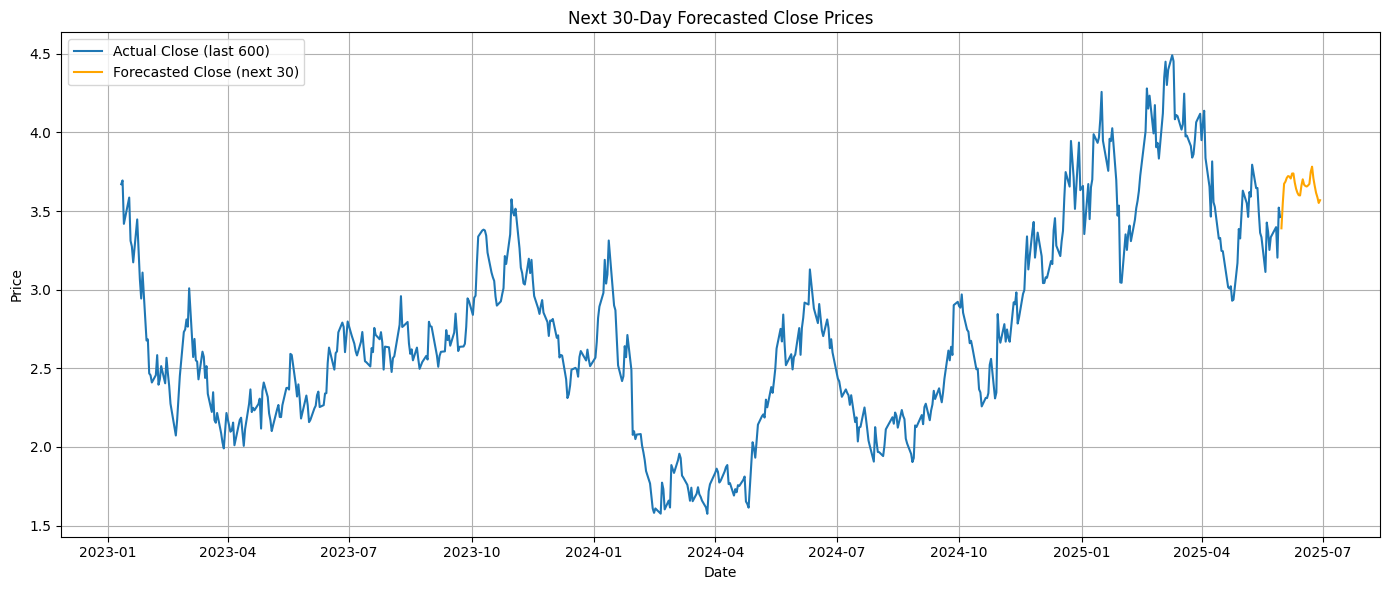

In [95]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(result['Date'].iloc[-600:], result['Close'].iloc[-600:], label="Actual Close (last 600)")
plt.plot(future_dates, future_close_prices, label="Forecasted Close (next 30)", linestyle='-', color='orange')
plt.title("Next 30-Day Forecasted Close Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()